In [1]:
import os
import sys
import subprocess
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'torch']) #pytorch
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'torchvision']) #pytorchvision
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pillow']) #PIL
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib']) #matplotlib
import torch as th
import torchvision as thvis
from PIL import Image
import matplotlib.pyplot as plt

# cuda support check
DEV = "cuda" if th.cuda.is_available() else "cpu"

In [2]:
class FaceDataset(th.utils.data.Dataset):
    # custom dataset
    def __init__(self, root, base_name, count, offset, extension, transform=None):
        self.filepaths = []
        self.count = count
        for i in range(self.count): # create filepaths
            self.filepaths.append(os.path.join(root, f"{base_name}{i+offset}.{extension}"))
        self.transform = transform

    def __len__(self):
        return self.count

    def __getitem__(self, index):
        # open image and load to memory
        img = Image.open(self.filepaths[index])
        
        # add transform
        if self.transform:
            img = self.transform(img)
        
        return img

In [3]:
class HopfieldNetwork(th.nn.Module):
    # hopfield network model
    def __init__(self, input_size):
        # initialization
        super(HopfieldNetwork, self).__init__()
        self.img_size = input_size
        self.N = input_size[-1]*input_size[-2]  # state vector size
        self.W = th.zeros(self.N, self.N).to(DEV)  # weight
        self.flatten = th.nn.Flatten().to(DEV)  # flatten layer
        # disables pytorch backprop
        for param in self.flatten.parameters():
            param.requires_grad = False
        self.I = th.eye(*self.W.shape).to(DEV)  # identity matrix with weight size

    def fit(self, Y):
        # store memory states
        for img in Y:
            img = self.flatten(img)  # flatten to 1 row
            self.W += (img.T @ img)  # element-wise multiplication
        self.W.fill_diagonal_(0)

    def energy(self, X):
        # calculate energy from memorized states
        X = self.flatten(X)  # flatten to 1 row
        return (-X @ self.W @ X.T).cpu()[0][0].item() # return energy from memorized states

    def restore(self, X, E_prev=None):
        # recursively restore image with memorized states until lowest energy
        # if initial call set E_prev to infinity
        if E_prev == None:
            E_prev = [float("inf")] * len(X)
        # if all done return batches of images    
        if all([E_prev_i == "DONE" for E_prev_i in E_prev]):
            return X  # return a batch of restored images
        else:
            for i, img in enumerate(X):
                # if done skip
                if E_prev[i] == "DONE": 
                    continue
                E = self.energy(img)  # calculate energy
                if E < E_prev[i]:  # if energy is lower
                    img = self.flatten(img)  # flatten to 1 row
                    img = th.sign(self.W @ img.T).T  # apply Activation based on McCullochPitts Model
                    X[i], E_prev[i] = img.reshape(self.img_size), E  # put back into batches
                else:
                    X[i], E_prev[i] = img.reshape(self.img_size), "DONE"  # put restored image into batches
            return self.restore(X, E_prev)


In [4]:
# compose transformations
transforms = thvis.transforms.Compose([
    thvis.transforms.ToTensor(), # convert pillow image to pytorch tensor
    thvis.transforms.Lambda(lambda x : x.to(DEV)), # move to cuda if available
    thvis.transforms.Lambda(lambda x : th.ceil(x) * 2 - 1), # convert to bipolar
    thvis.transforms.Lambda(lambda x : x * -1) # invert output
])

# create training and test datasets
train_dataset = FaceDataset("./", "bin_image", 5, 1, "gif" , transforms)
test_dataset = FaceDataset("./", "bin_corr", 3, 1, "gif" , transforms)

# create training and test dataloaders
train_loader = th.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = th.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
# train model
train_iter = iter(train_loader)
input_size = [1,*train_dataset[0].shape]
model = HopfieldNetwork(input_size) # initialize model
model = model.to(DEV) # move model to cuda if available
for img in train_iter: # train per batch
    model.fit(img)

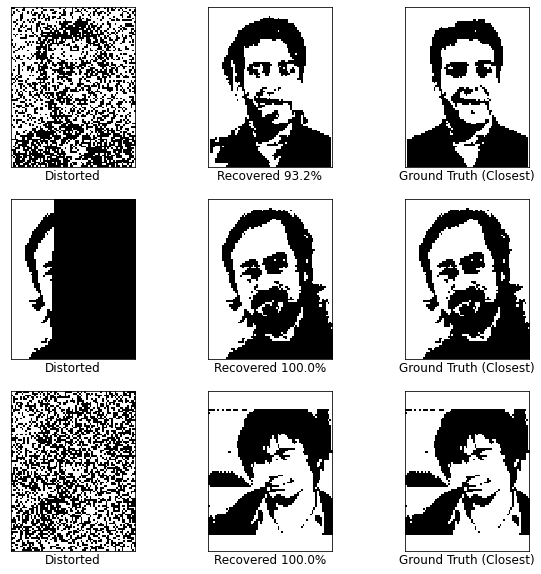

In [6]:
# test model and display
def get_closest_image(Y, train_loader):
    # find closest image and compares accuracy
    iters = iter(train_loader)
    accr = []
    imgr = []

    for check in Y:
        hiaccs = 0
        himgs = th.ones(check.shape).to(DEV)
        for img in iters:
            acc = ((check[0] == img).sum()/img.reshape(-1).shape[0]).cpu().item()*100
            if acc > hiaccs:
                hiaccs = acc
                himgs = img
        accr.append(hiaccs)
        imgr.append(himgs)

    return imgr, accr 


test_iter = iter(test_loader)

# comparing with real image
fig,ax = plt.subplots(len(test_iter),3,figsize=(10,10),facecolor='white')
for i,img in enumerate(test_iter):
    ax[i][0].imshow(img[0][0].cpu(),cmap='binary', interpolation='none')
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    ax[i][0].set_title('Distorted', y=-0.12)
    test_restore = model.restore(img)
    ax[i][1].imshow(test_restore[0][0].cpu(),cmap='binary', interpolation='none')
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    imgr, accr = get_closest_image(test_restore, train_loader)
    ax[i][1].set_title(f'Recovered {accr[0]:.1f}%', y=-0.12)
    ax[i][2].imshow(imgr[0].cpu()[0][0],cmap='binary', interpolation='none')
    ax[i][2].set_xticks([])
    ax[i][2].set_yticks([])
    ax[i][2].set_title('Ground Truth (Closest)', y=-0.12)


